<a href="https://colab.research.google.com/github/siddosi/CAIC-Summer-25-IITD/blob/main/AI_DEVCLUB_IITD_TWITTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

shape (17331, 7)
tail           id              date  likes  \
17326  17327  12-12-2020 03:15     56   
17327  17328  09-02-2018 21:47      2   
17328  17329  03-05-2018 14:26    181   
17329  17330  27-01-2020 11:52      0   
17330  17331  10-03-2020 02:58    112   

                                                  tweets        username  \
17326  After 66 years together, this couple died of #...       cbcnewsbc   
17327  Where to add wireless measurements &amp;amp; a...  EMR_Automation   
17328  This is what happened outside a Bromley pollin...     Independent   
17329  Int’l Day Of Education: CSO Sensitises Childre...  IndependentNGR   
17330  Happy Tuesday \nWelcome to #TheMorningFlava\nW...       METROFMSA   

                                                   media inferred company  
17326  [Video(thumbnailUrl='https://pbs.twimg.com/amp...              cbc  
17327  [Photo(previewUrl='https://pbs.twimg.com/media...          emerson  
17328  [Video(thumbnailUrl='https://pbs.twimg.

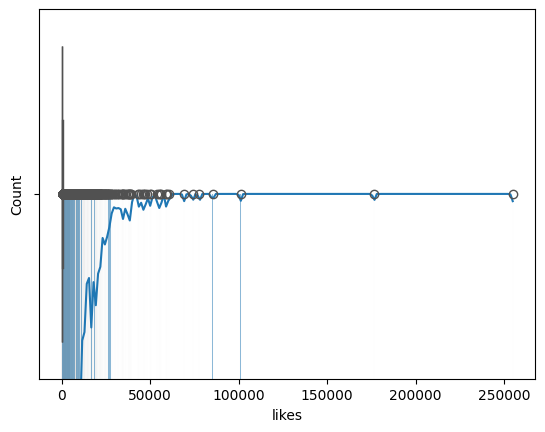

In [11]:
import pandas as pd

df = pd.read_csv("behaviour_simulation_train.csv")  # replace with your actual path

print("shape",df.shape)
print("tail",df.tail())
print("info",df.info())
print("nullvalues",df.isnull().sum())



import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['likes'], kde=True)
sns.boxplot(x=df['likes'])



df['tweets'] = df['tweets'].str.lower()

print("lowering_values",df['tweets'].head())





print("describe",df['likes'].describe())





word_dict = df['tweets'].str.split().explode().value_counts().to_dict()



print("shape",df.shape)
print("tail",df.tail())
print("info",df.info())
print("nullvalues",df.isnull().sum())






In [38]:
#df.dropna(subset=['content', 'username', 'company', 'likes'], inplace=True)
df['media'] = df['media'].fillna('0')
df['has_media'] = df['media'].apply(lambda x: x != 'no_media')

df['datetime'] = pd.to_datetime(df['date'], errors='coerce')







In [40]:
print("tail",df.tail())


#lowercased, no media term added

tail           id              date  likes  \
17326  17327  12-12-2020 03:15     56   
17327  17328  09-02-2018 21:47      2   
17328  17329  03-05-2018 14:26    181   
17329  17330  27-01-2020 11:52      0   
17330  17331  10-03-2020 02:58    112   

                                                  tweets        username  \
17326  after 66 years together, this couple died of #...       cbcnewsbc   
17327  where to add wireless measurements &amp;amp; a...  EMR_Automation   
17328  this is what happened outside a bromley pollin...     Independent   
17329  int’l day of education: cso sensitises childre...  IndependentNGR   
17330  happy tuesday \nwelcome to #themorningflava\nw...       METROFMSA   

                                                   media inferred company  \
17326  [Video(thumbnailUrl='https://pbs.twimg.com/amp...              cbc   
17327  [Photo(previewUrl='https://pbs.twimg.com/media...          emerson   
17328  [Video(thumbnailUrl='https://pbs.twimg.com/ext...    

In [41]:
df['word_count'] = df['tweets'].apply(lambda x: len(x.split()))
df['char_count'] = df['tweets'].apply(len)

print(df['word_count'])
print(df["char_count"])

0        29
1        10
2        14
3        22
4        26
         ..
17326    16
17327    21
17328    23
17329    12
17330    17
Name: word_count, Length: 17331, dtype: int64
0        181
1         73
2        104
3        140
4        199
        ... 
17326    100
17327    173
17328    136
17329     86
17330    141
Name: char_count, Length: 17331, dtype: int64


In [42]:
def calculate_word_occurrence_probabilities(df, like_thresholds=[10, 20, 100, 1000]):
    results = {}

    for threshold in like_thresholds:
        # Filter tweets with likes > threshold
        filtered_df = df[df['likes'] > threshold]
        total_tweets = len(filtered_df)

        if total_tweets == 0:
            results[f'likes_>{threshold}'] = {}
            continue

        # Get unique words from all filtered tweets
        all_words = set()
        for tweet in filtered_df['tweets']:
            if pd.notna(tweet):
                all_words.update(tweet.split())

        # Calculate probability of each word appearing in a tweet
        word_probabilities = {}
        for word in all_words:
            # Count tweets containing this word
            tweets_with_word = filtered_df['tweets'].str.contains(rf'\b{word}\b', na=False).sum()
            probability = tweets_with_word / total_tweets
            word_probabilities[word] = probability

        results[f'likes_>{threshold}'] = word_probabilities

    return results

# Use the function
occurrence_probabilities = calculate_word_occurrence_probabilities(df)

KeyboardInterrupt: 

#TD-IDF

In [43]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import math



def calculate_sklearn_tfidf(df, like_thresholds=[1]):
    """
    Calculate TF-IDF using sklearn's TfidfVectorizer
    """
    results = {}

    for threshold in like_thresholds:
        # Filter tweets with likes > threshold
        filtered_df = df[df['likes'] > threshold]

        if len(filtered_df) == 0:
            results[f'likes_>{threshold}'] = {}
            continue

        tweets = filtered_df['tweets'].dropna().tolist()

        if len(tweets) == 0:
            results[f'likes_>{threshold}'] = {}
            continue

        # Use TfidfVectorizer with log scaling
        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words=None,  # Set to 'english' if you want to remove stop words
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True  # This applies log scaling to TF
        )

        # Fit and transform the tweets
        tfidf_matrix = vectorizer.fit_transform(tweets)
        feature_names = vectorizer.get_feature_names_out()

        # Calculate average TF-IDF scores across all documents
        avg_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)

        # Create dictionary with word: avg_tfidf_score
        word_tfidf = {}
        for i, word in enumerate(feature_names):
            word_tfidf[word] = {
                'avg_tfidf': avg_tfidf_scores[i],
                'idf': vectorizer.idf_[i]
            }

        results[f'likes_>{threshold}'] = word_tfidf

    return results

def display_top_tfidf_words(tfidf_results, top_n=10):
    """
    Display top N words by TF-IDF score for each threshold
    """
    for threshold, words in tfidf_results.items():
        print(f"\n{threshold} - Top {top_n} words by TF-IDF:")
        print("-" * 50)

        if not words:
            print("No data available")
            continue

        # Sort by average TF-IDF score
        sorted_words = sorted(words.items(),
                            key=lambda x: x[1]['avg_tfidf'],
                            reverse=True)[:top_n]

        for word, scores in sorted_words:
          print(f"{word:<15} TF-IDF: {scores['avg_tfidf']:.4f}")

def compare_words_across_thresholds(tfidf_results, words_to_compare):
    """
    Compare specific words across different like thresholds
    """
    print(f"\nComparison of words across thresholds:")
    print("-" * 60)

    # Create header
    thresholds = list(tfidf_results.keys())
    header = f"{'Word':<15}"
    for threshold in thresholds:
        header += f"{threshold:<15}"
    print(header)
    print("-" * 60)

    for word in words_to_compare:
        row = f"{word:<15}"
        for threshold in thresholds:
            if word in tfidf_results[threshold]:
                score = tfidf_results[threshold][word]['avg_tfidf']
                row += f"{score:<15.4f}"
            else:
                row += f"{'N/A':<15}"
        print(row)

# Example usage


sklearn_results = calculate_sklearn_tfidf(df)
display_top_tfidf_words(sklearn_results, top_n=1000)

    # Compare specific words



    # Calculate TF-IDF manually (for understanding)
print("\n" + "="*60)
print("Manual TF-IDF Calculation (for verification)")
print("="*60)








likes_>1 - Top 1000 words by TF-IDF:
--------------------------------------------------
hyperlink       TF-IDF: 0.0530
the             TF-IDF: 0.0427
mention         TF-IDF: 0.0366
to              TF-IDF: 0.0343
and             TF-IDF: 0.0268
in              TF-IDF: 0.0262
of              TF-IDF: 0.0258
for             TF-IDF: 0.0230
you             TF-IDF: 0.0207
on              TF-IDF: 0.0204
is              TF-IDF: 0.0193
with            TF-IDF: 0.0181
this            TF-IDF: 0.0163
it              TF-IDF: 0.0161
at              TF-IDF: 0.0159
we              TF-IDF: 0.0157
your            TF-IDF: 0.0155
our             TF-IDF: 0.0131
from            TF-IDF: 0.0128
are             TF-IDF: 0.0120
that            TF-IDF: 0.0114
more            TF-IDF: 0.0108
new             TF-IDF: 0.0104
all             TF-IDF: 0.0102
be              TF-IDF: 0.0101
now             TF-IDF: 0.0097
here            TF-IDF: 0.0093
get             TF-IDF: 0.0092
by              TF-IDF: 0.0090
amp         

playing with text blob



In [44]:
from textblob import TextBlob

In [45]:
word = "i think the movie is very very bad and is a disaster"
TextBlob(word).sentiment.polarity



-0.9099999999999998

In [67]:
df['sentiment'] = df['tweets'].apply(lambda tweet: 1000*TextBlob(tweet).sentiment.polarity)

print(df['sentiment'])


0        175.0
1          0.0
2       -100.0
3        500.0
4         62.5
         ...  
17326      0.0
17327      0.0
17328      0.0
17329      0.0
17330    800.0
Name: sentiment, Length: 17331, dtype: float64


In [68]:
print(df['sentiment'].describe())

count    17331.000000
mean       152.968900
std        266.507745
min      -1000.000000
25%          0.000000
50%         53.333333
75%        300.000000
max       1000.000000
Name: sentiment, dtype: float64


In [69]:
print(df.describe())

                 id          likes    word_count    char_count     sentiment  \
count  17331.000000   17331.000000  17331.000000  17331.000000  17331.000000   
mean    8666.000000     718.392130     22.501356    147.868617    152.968900   
min        1.000000       0.000000      2.000000     20.000000  -1000.000000   
25%     4333.500000       3.000000     12.000000     88.000000      0.000000   
50%     8666.000000      73.000000     21.000000    136.000000     53.333333   
75%    12998.500000     352.000000     31.000000    202.000000    300.000000   
max    17331.000000  254931.000000     63.000000    323.000000   1000.000000   
std     5003.173093    3866.475948     11.842720     71.690684    266.507745   

                            datetime  
count                           6832  
mean   2019-07-24 10:53:54.651639552  
min              2018-01-01 06:23:00  
25%              2018-11-04 04:02:45  
50%              2019-08-10 20:29:30  
75%              2020-04-11 12:21:30  
max   

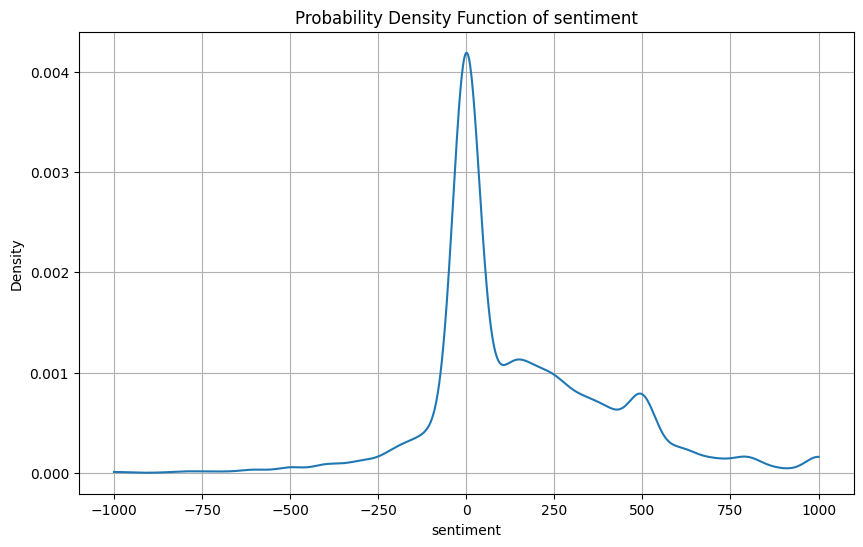

In [70]:

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np


def plot_pdf(df, feature_name):
    """
    Plots the probability density function for a given feature in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        feature_name (str): The name of the feature to plot.
    """
    data = df[feature_name].dropna()  # Extract data, removing NaN values
    if len(data) == 0:
        print("No valid data for the selected feature.")
        return

    kde = gaussian_kde(data)  # Create a KDE object
    xs = np.linspace(min(data), max(data), 1000)  # Generate x values for plotting
    density = kde(xs)  # Compute density values

    plt.figure(figsize=(10, 6))
    plt.plot(xs, density)
    plt.title(f'Probability Density Function of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


# Example Usage
# Assuming your DataFrame is named 'df' and your feature is 'my_feature'
# Create a sample DataFrame for demonstration


plot_pdf(df, 'sentiment')

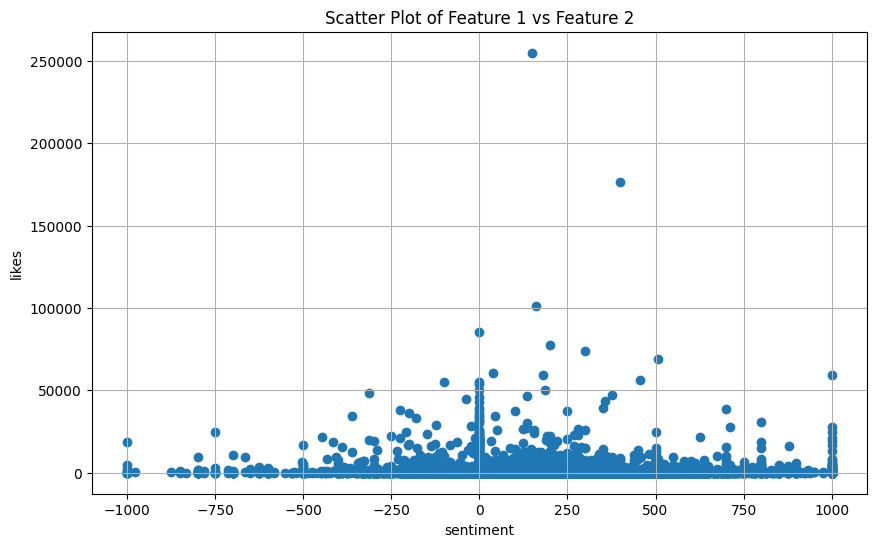

In [71]:






# Create the scatter plot
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.scatter(df['sentiment'], df['likes'])

# Add labels and title
plt.xlabel('sentiment')
plt.ylabel('likes')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()

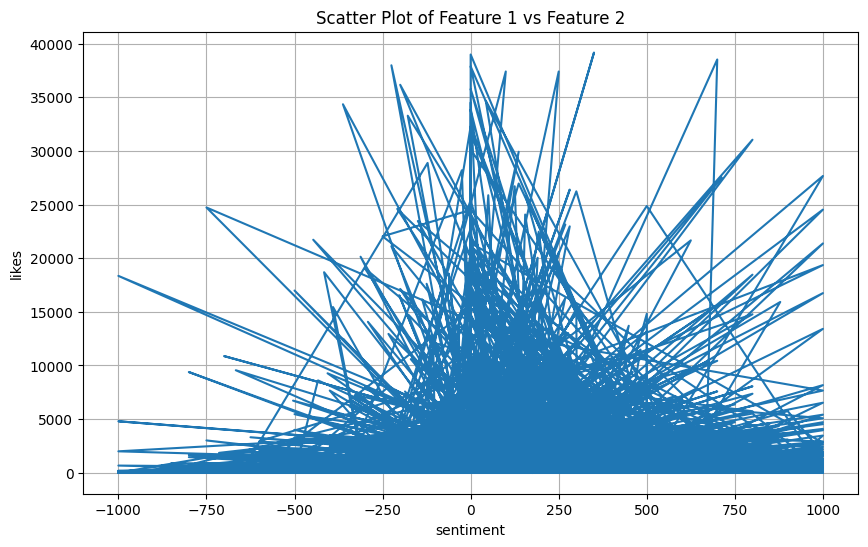

In [87]:
df_f = df[df['likes'] < 40000]
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.plot(df_f['sentiment'], df_f['likes'])

# Add labels and title
plt.xlabel('sentiment')
plt.ylabel('likes')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()

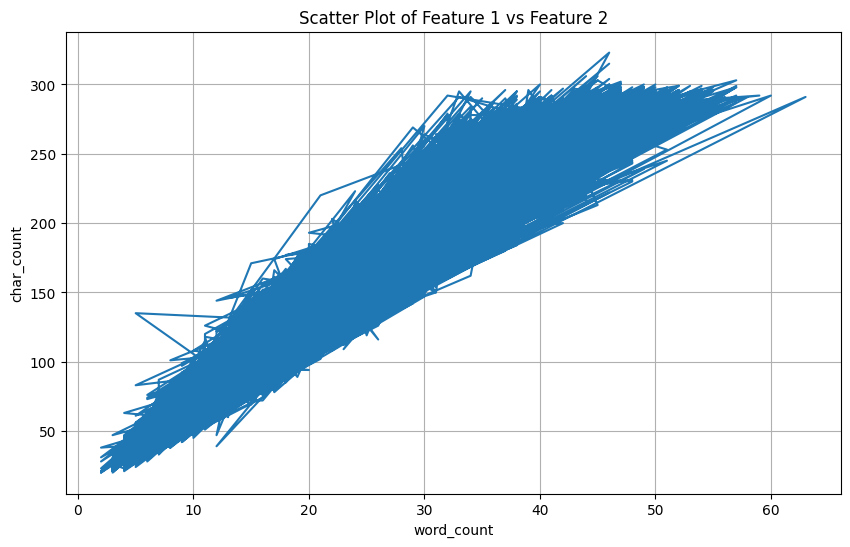

In [89]:
# Create the scatter plot
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.plot(df['word_count'], df['char_count'])

# Add labels and title
plt.xlabel('word_count')
plt.ylabel('char_count')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()

THE PLOT OF SENTIMENT VS LIKES SEEMS LIKE GAUSSIAN


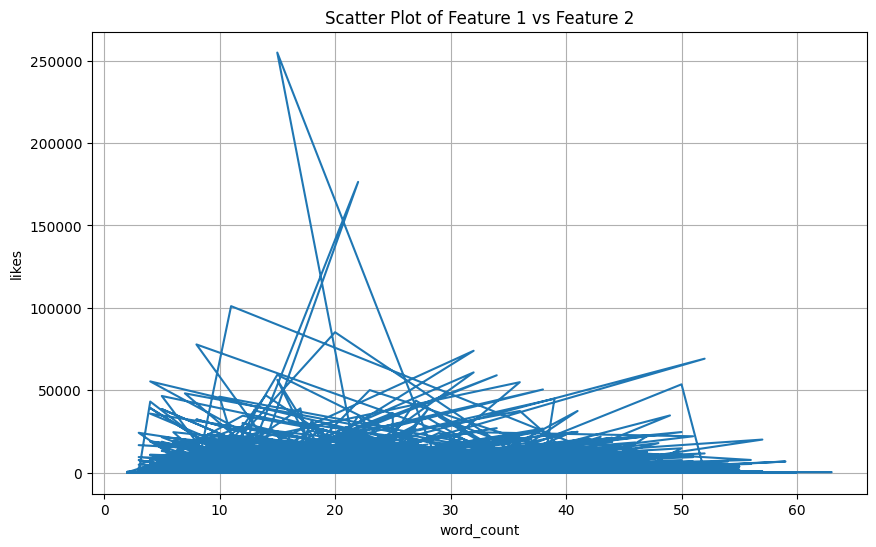

In [86]:
df_f = df[df['likes'] < 1000000]
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.plot(df_f['word_count'], df_f['likes'])

# Add labels and title
plt.xlabel('word_count')
plt.ylabel('likes')
plt.title('Scatter Plot of Feature 1 vs Feature 2')

# Display the plot
plt.grid(True) # Add grid lines
plt.show()